In [2]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [6]:
class AgentState(TypedDict):
    messages: List[HumanMessage]

In [5]:
llm = ChatOpenAI(model = "gpt-4o")

In [7]:
def process(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(f"\n AI: {response.content}")
    return state

In [8]:
graph = StateGraph(AgentState)

graph.add_node("process_node", process)
graph.add_edge(START, "process_node")
graph.add_edge("process_node", END)

app = graph.compile()

In [10]:
user_input = input("Enter:")
result = app.invoke({"messages": [HumanMessage(content=user_input)]})

print(result)


 AI: I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with whatever you need! How can I assist you today?
{'messages': [HumanMessage(content='how are you doing?', additional_kwargs={}, response_metadata={})]}


In [11]:
import os
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

In [12]:
load_dotenv()

True

In [13]:
class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]]

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

In [14]:
def process(state: AgentState) -> AgentState:
    """ ddd"""
    response = llm.invoke(state["messages"])
    state["messages"].append(AIMessage(content=response.content))
    print(f"\n AI: {response.content}")

    return state

In [15]:
graph = StateGraph(AgentState)

graph.add_node("process_node", process)
graph.add_edge(START, "process_node")
graph.add_edge("process_node", END)

app = graph.compile()

conversation_history = []

In [19]:
user_input = input("Enter: ")
conversation_history.append(HumanMessage(content=user_input))
result = app.invoke({"messages": conversation_history})
print(f"result:{result}")
conversation_history = result["messages"]
print(f"History conversation: {conversation_history}")


 AI: Your name is Jerry.
result:{'messages': [HumanMessage(content='Hi, my name is Jerry', additional_kwargs={}, response_metadata={}), AIMessage(content='Hello Jerry! How can I assist you today?', additional_kwargs={}, response_metadata={}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}), AIMessage(content='Your name is Jerry.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is Phenylephrine used for?', additional_kwargs={}, response_metadata={}), AIMessage(content="Phenylephrine is a medication commonly used as a decongestant to relieve nasal congestion caused by colds, allergies, or sinus infections. It works by constricting blood vessels in the nasal passages, which reduces swelling and congestion. Phenylephrine can be found in oral forms, such as tablets and syrups, as well as in nasal sprays and ophthalmic solutions for other uses like treating redness in the eyes. It's important to follow the dosage instructions and

In [25]:
lst = [1, 2, 3, 4, 5, 6, 7]
last_three = lst[: -1]
print(last_three)

[1, 2, 3, 4, 5, 6]


In [134]:
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [135]:
load_dotenv()

True

In [136]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # add_messages will automatically append messages to the list.

@tool
def add(a: int, b: int):
    """add two numbers"""
    return a + b

@tool
def substract(a: int, b: int):
    """Substract two numbers"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiply two numbers"""
    return a * b

tools = [add, substract, multiply]

model = ChatOpenAI(model = "gpt-4o").bind_tools(tools)

In [137]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content="You are my AI assistant, please answer my query to the best of your ability."
    )
    #print([system_prompt] + state["messages"])
    response = model.invoke([system_prompt] + state["messages"])
    #print(response)
    return AgentState({"messages": [response]})

In [138]:
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_massage = messages[-1]
    print(last_massage)
    if last_massage.tool_calls:
        return "continue"
    else:
        return "end"

In [139]:
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tool", tool_node)

graph.add_edge(START, "our_agent")

graph.add_conditional_edges(
    source="our_agent",
    path=should_continue,
    path_map={
        "continue": "tool",
        "end": END,
    },
)

graph.add_edge("tool", "our_agent")

app = graph.compile()

In [140]:
def print_stream(stream):

    for s in stream:
        message = s["messages"][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

In [141]:
input = {"messages": ["user", "add 40 + 4, then use the result multiply by 2. Finally, determin whether 'How are you doing?' is a clinical question"]}

print_stream(app.stream(input, stream_mode="values"))

================================ Human Message =================================

add 40 + 4, then use the result multiply by 2. Finally, determin whether 'How are you doing?' is a clinical question
content='' additional_kwargs={'tool_calls': [{'id': 'call_zD6yyQy6zfSzfCHiPTH4kwJY', 'function': {'arguments': '{"a": 40, "b": 4}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_eR49090Yx95AcTINAhMnfagt', 'function': {'arguments': '{"a": 44, "b": 2}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 140, 'total_tokens': 190, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f33640a400', 'id': 'chatcmpl-CKbyUqIzP7JifDMYp1DvvN4Ay22VI', 'service_tier': 'default', 'finish_reason': 'tool_call

In [2]:
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [3]:
load_dotenv()

True

In [4]:
document_content = ""

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages] # add_messages will automatically append messages to the list.

In [6]:
@tool
def update(content: str) -> str:
    """Updates the document with the provided content"""
    global document_content
    document_content = content
    return f"Document has been updated successfully! The current content is:\n{document_content}"

def save(filename: str) -> str:
    """ 
    save the current document to a text file and finish the process

    Args:
        filename: Name for the text file.
    """
    global document_content
    if not filename.endswith(".txt"):
        filename = f"{filename}.txt"

    try:
        with open(filename,"w") as file:
            file.write(document_content)

        print(f"\n Document has been saved to: {filename}")

        return f"Document has been saved to: {filename}"
    except Exception as e:
        return f"Error saving document:{str(e)}"
    

tools = [update, save]


In [7]:
model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [10]:
def our_agent(state: AgentState) -> AgentState:
    #global document_content
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.

    The current document content is: {document_content}                                                                                                                        
    """)

    if not state["messages"]:
        user_input = "I'am ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)
    else:
        user_input = input("\nWhat would you like to do with the document?")
        print(f"\n USER:{user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = model.invoke(all_messages)

    print(f"\n AI: {response.content}")

    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"""USING TOOLS: {[tc["name"] for tc in response.tool_calls]}""")

    return {"messages": list(state["messages"]) + [user_message, response]}

def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation"""
    
    messages = state["messages"]

    if not messages:
        return "continue"
    
    for message in reversed(messages):
        if(isinstance(message, ToolMessage)) and "saved" in message.content.lower() and "document" in message.content.lower():
            return "end"
        
    return "continue"


def print_messages(messages):
    """Pretty printer"""

    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"Tool result: {message.content}")



In [11]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "agent")
graph.add_edge("agent", "tools")

graph.add_conditional_edges(
    source="tools",
    path=should_continue,
    path_map={
        "continue": "agent",
        "end": END
    }
)

app = graph.compile()

In [12]:
def run_document_agent():
    print("\n====Drafter====\n")

    state = AgentState(messages=[])

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n==========Drafter end =================")

In [17]:
run_document_agent()


====Drafter====


 AI: It seems you want to make some changes to the document. Please let me know what updates or modifications you'd like to make to the current document.

 USER:I don't feel good today

 AI: If you'd like to update the document to reflect this, we can include a note mentioning you're unwell, and perhaps suggest rescheduling due to not feeling well. Would you like me to make that change?

 USER:so i need to send a message to my friend to tell him I can not have diner with him. Can you write me the message?

 AI: Certainly! Here's a message you could consider sending:

---

Hi [Friend's Name],

I hope you're doing well. I wanted to let you know that I'm not feeling well today and, unfortunately, won't be able to make it to our dinner. I'm really sorry for the sudden change of plans.

Let's definitely try to reschedule for another time when I'm feeling better. I appreciate your understanding.

Take care,

Jerry

---

Would you like to replace the current document conten

In [1]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
#from operator import add as add_messages
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from rerank_rag import Rerank_RAG
from IPython.display import Image, display

W0928 14:18:46.155000 32404 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.1)

In [4]:
rag = Rerank_RAG()

In [5]:
rag.setup_retriever()

setup_retriever starts runing!
Login HuggingFace!
load_embedding_model starts runing!


You are trying to use a model that was created with Sentence Transformers version 5.2.0.dev0, but you're currently using version 5.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


load_embedding_model took 4.7494s
load_crossencoder starts runing!
load_crossencoder took 1.2778s
setup_retriever took 7.7249s


In [6]:
@tool
def retriever_tool(query: str) -> str:
    """Any question involving diagnosis, treatment, dosing, interactions, adverse effects,
      contraindications, labs, imaging, vaccines, pregnancy/lactation, geriatrics/pediatrics,
      guideline recommendations, or clinical decision support. Use this tool BEFORE answering medical questions. 
      Arg:
        query: str

      return: str
    """

    docs = rag.retrieve(query, top_k=5)

    result = []

    for i, doc in enumerate(docs):
        result.append(f"Document {i+1}:\n{doc.page_content}")

    return "\n\n".join(result)

@tool
def add(a: int, b: int):
    """add two numbers"""
    return a + b

In [7]:
tools = [retriever_tool]
#llm.bind_tools(tools)
llm = llm.bind_tools(tools)

In [8]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [9]:
def should_continue(state: AgentState)-> str:
    """check if the last message contains tool call"""

    print(state['messages'])
    result = state['messages'][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0

In [10]:
System_prompt = """ 
You are a **careful medical assistant**. Please trigger a tool_calls of retriever_tool, If the user’s query **requires or could influence medical/clinical decisions.
you **must first** call the `retriever_tool` to fetch evidence before forming any answer.

"""

In [11]:
tool_dict = {our_tool.name:our_tool for our_tool in tools}

In [12]:
def call_llm(state: AgentState) -> AgentState:
    messages = list(state["messages"])
    messages = [SystemMessage(content=System_prompt)] + messages
    print(messages)
    message = llm.invoke(messages) #if the query is asking clinical information, it will return a tool calling message.
        
    return {"messages": [message]}


In [17]:
def take_action(state: AgentState) -> AgentState:
    """Excute tool calls from the LLM's response."""

    tool_calls = state["messages"][-1].tool_calls

    results = []

    for t in tool_calls:
        print(f"""calling Tool:{t["name"]} with query: {t["args"].get("query", "No query provided")}""")

        if not t["name"] in tool_dict:
            print(f"""\nTool: {t["name"]} does not exist.""")
            result = "Incorrect tool name, please Retry and select tool from list of Available tools"
        else:
            result = tool_dict[t["name"]].invoke(t["args"].get("query",""))
            print(f"Result length:{len(str(result))}")

        results.append(ToolMessage(tool_call_id = t["id"], name=t["name"],content=str(result)))

    print("Tools excution complete. Back to the model")

    return {"messages": results}

In [18]:
graph = StateGraph(AgentState)

graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_edge(START, "llm")
graph.add_edge("retriever_agent", "llm")
graph.add_conditional_edges(
    source="llm",
    path=should_continue,
    path_map={
        True: "retriever_agent",
        False: END
    }
)

app = graph.compile()

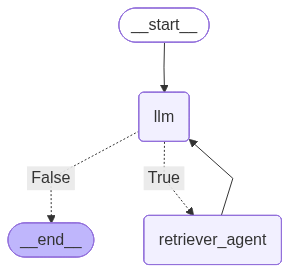

In [15]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [21]:
messages = []
while True:
    user_input = input("\nWhat is your question: ")

    if user_input.strip().lower() in ["exit", "end"]:
        break

    messages = messages + [HumanMessage(content=user_input)]

    #state = AgentState(messages=messages)

    result = app.invoke({"messages": messages})

    print(result)

    print("===Answer===\n")
    print(result['messages'][-1].content)
    messages = messages + result['messages']

[SystemMessage(content=' \nYou are a **careful medical assistant**. Please trigger a tool_calls of retriever_tool, If the user’s query **requires or could influence medical/clinical decisions.\nyou **must first** call the `retriever_tool` to fetch evidence before forming any answer.\n\n', additional_kwargs={}, response_metadata={}), HumanMessage(content='good afternoon', additional_kwargs={}, response_metadata={}, id='8c9c808a-a5a2-4b32-ab08-df4cc195b565')]
[HumanMessage(content='good afternoon', additional_kwargs={}, response_metadata={}, id='8c9c808a-a5a2-4b32-ab08-df4cc195b565'), AIMessage(content='Good afternoon! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 157, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},